Forward Diffusion

In [ ]:
#cell 1
import os, glob, math, subprocess, sys, random
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def seed_everything(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)

seed_everything(42)
device = get_device()
print("Device:", device)


Device: cuda


In [ ]:
#cell 2
class ImageFolderNoLabel(Dataset):
    """
    从文件夹递归读取图片；转 28×28 RGB；数值规范到 [-1,1]。
    """
    def __init__(self, root: str, image_size: int = 28):
        self.paths = []
        for ext in ("*.png","*.jpg","*.jpeg","*.bmp","*.webp"):
            self.paths += glob.glob(os.path.join(root, "**", ext), recursive=True)
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found under {root}")

        try:
            self.transform = T.Compose([
                T.Resize((image_size, image_size), interpolation=T.InterpolationMode.BILINEAR, antialias=True),
                T.ToTensor(),  # [0,1]
            ])
        except TypeError:
            self.transform = T.Compose([
                T.Resize((image_size, image_size), interpolation=T.InterpolationMode.BILINEAR),
                T.ToTensor(),
            ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x = self.transform(img)  # (3,H,W) in [0,1]
        x = x * 2.0 - 1.0        # -> [-1,1]
        return x


In [ ]:
#cell 3
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: (B,)
        device = t.device
        half = self.dim // 2
        denom = max(1, half - 1)
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device).float() / denom)
        args = t[:, None].float() * freqs[None]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb

def conv3(in_ch, out_ch, k=3, s=1, p=1):
    return nn.Conv2d(in_ch, out_ch, k, s, p)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        self.block1 = nn.Sequential(nn.GroupNorm(8, in_ch), nn.SiLU(), conv3(in_ch, out_ch))
        self.block2 = nn.Sequential(nn.GroupNorm(8, out_ch), nn.SiLU(), conv3(out_ch, out_ch))
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x, t_emb):
        h = self.block1(x)
        t_feat = self.mlp(t_emb)[:, :, None, None]
        h = h + t_feat
        h = self.block2(h)
        return h + self.res(x)

class UNet(nn.Module):
    def __init__(self, img_ch=3, base=64, time_dim=128):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim*4),
            nn.SiLU(),
            nn.Linear(time_dim*4, time_dim)
        )
        # Down: 28->14->7
        self.in_conv = conv3(img_ch, base)
        self.rb1 = ResBlock(base, base, time_dim)
        self.down1 = nn.Conv2d(base, base*2, 4, 2, 1)  # 28->14
        self.rb2 = ResBlock(base*2, base*2, time_dim)
        self.down2 = nn.Conv2d(base*2, base*4, 4, 2, 1)  # 14->7
        self.rb3 = ResBlock(base*4, base*4, time_dim)

        # Mid
        self.mid1 = ResBlock(base*4, base*4, time_dim)
        self.mid2 = ResBlock(base*4, base*4, time_dim)

        # Up: 7->14->28
        self.up1 = nn.ConvTranspose2d(base*4, base*2, 4, 2, 1)  # 7->14
        self.rb4 = ResBlock(base*2 + base*2, base*2, time_dim)
        self.up2 = nn.ConvTranspose2d(base*2, base, 4, 2, 1)    # 14->28
        self.rb5 = ResBlock(base + base, base, time_dim)

        self.out = nn.Sequential(nn.GroupNorm(8, base), nn.SiLU(), conv3(base, img_ch, 3, 1, 1))

    def forward(self, x, t):  # 预测噪声 eps
        t_emb = self.time_emb(t)
        x1 = self.in_conv(x); x1 = self.rb1(x1, t_emb)
        x2 = self.down1(x1);  x2 = self.rb2(x2, t_emb)
        x3 = self.down2(x2);  x3 = self.rb3(x3, t_emb)
        m  = self.mid1(x3, t_emb); m = self.mid2(m, t_emb)
        u1 = self.up1(m); u1 = torch.cat([u1, x2], dim=1); u1 = self.rb4(u1, t_emb)
        u2 = self.up2(u1); u2 = torch.cat([u2, x1], dim=1); u2 = self.rb5(u2, t_emb)
        return self.out(u2)


In [ ]:
#cell 4
class Diffusion(nn.Module):
    def __init__(self, timesteps=1000, beta_schedule="linear"):
        super().__init__()
        self.T = timesteps
        self.register_buffer("betas", self.make_beta_schedule(beta_schedule, timesteps))
        alphas = 1.0 - self.betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=alphas.device), alphas_cumprod[:-1]], dim=0)

        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)

        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod))
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))

        posterior_variance = self.betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        self.register_buffer("posterior_variance", posterior_variance.clamp(min=1e-20))
        self.register_buffer("posterior_log_variance", torch.log(self.posterior_variance))

    @staticmethod
    def make_beta_schedule(name: str, timesteps: int) -> torch.Tensor:
        if name == "linear":
            return torch.linspace(1e-4, 0.02, timesteps)
        elif name == "cosine":
            s = 0.008
            steps = timesteps + 1
            x = torch.linspace(0, timesteps, steps)
            alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            return betas.clamp(1e-4, 0.999)
        else:
            raise ValueError(f"unknown schedule: {name}")

    @torch.no_grad()
    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, noise: torch.Tensor = None) -> torch.Tensor:
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_t      = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_t * noise

    def p_mean_variance(self, model: nn.Module, x_t: torch.Tensor, t: torch.Tensor):
        eps_pred = model(x_t, t.float())
        beta_t      = self.betas[t][:, None, None, None]
        sqrt_recip  = self.sqrt_recip_alphas[t][:, None, None, None]
        sqrt_one_m  = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        mean        = sqrt_recip * (x_t - beta_t / sqrt_one_m * eps_pred)
        var         = self.posterior_variance[t][:, None, None, None]
        return mean, var, eps_pred

    @torch.no_grad()
    def p_sample(self, model: nn.Module, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        mean, var, _ = self.p_mean_variance(model, x_t, t)
        if (t == 0).all():
            return mean
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(var) * noise

    @torch.no_grad()
    def sample(self, model: nn.Module, shape: Tuple[int,int,int,int], device: torch.device,
               timesteps: int = None, record_steps: List[int] = None):
        T = self.T if timesteps is None else timesteps
        x = torch.randn(shape, device=device)
        records = []
        rec_set = set(int(s) for s in (record_steps or []))
        for i in reversed(range(T)):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)
            x = self.p_sample(model, x, t)
            if i in rec_set:
                records.append(x.detach().clamp(-1,1).cpu())
        return x.clamp(-1,1), records


In [ ]:
#cell 5
class EMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.model = model
        # Initialize shadow on the same device as the model
        self.shadow = {k: v.detach().clone().to(v.device) for k, v in model.state_dict().items()}
        self.decay = decay
    def update(self):
        with torch.no_grad():
            for k, v in self.model.state_dict().items():
                # Ensure v is on the correct device before the operation
                self.shadow[k].mul_(self.decay).add_(v.detach().to(self.shadow[k].device), alpha=1 - self.decay)

In [ ]:
#cell 6
def train(
    data_dir: str,
    out_dir: str = "runs/ddpm_mnist",
    epochs: int = 20,
    batch_size: int = 256,
    lr: float = 2e-4,
    timesteps: int = 1000,
    beta_schedule: str = "linear",
    base: int = 64,
    workers: int = 4,
    resume: bool = False,
):
    os.makedirs(out_dir, exist_ok=True)
    device = get_device()

    # Data
    ds = ImageFolderNoLabel(data_dir, image_size=28)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)

    # Model + diffusion + EMA
    model = UNet(img_ch=3, base=base).to(device)
    diffusion = Diffusion(timesteps=timesteps, beta_schedule=beta_schedule).to(device)
    ema = EMA(model) # EMA is initialized with model parameters already on the correct device

    opt = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999))
    ckpt_path = os.path.join(out_dir, "latest.pt")
    ema_path  = os.path.join(out_dir, "ema_latest.pt")
    best_ckpt_path = os.path.join(out_dir, "best.pt")
    best_ema_path = os.path.join(out_dir, "ema_best.pt")

    start_epoch = 0
    best_loss = float('inf')

    if resume and os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device) # Load checkpoint to the correct device
        model.load_state_dict(ckpt["model"])
        opt.load_state_dict(ckpt["opt"])
        start_epoch = ckpt["epoch"] + 1
        if os.path.exists(ema_path):
            try:
                # Load EMA shadow to the correct device
                ema.shadow = {k: v.to(device) for k, v in torch.load(ema_path, map_location=device).items()}
            except Exception as e:
                print("[WARN] EMA restore failed:", e)
        # Load best loss if best checkpoint exists
        if os.path.exists(best_ckpt_path):
            best_ckpt = torch.load(best_ckpt_path, map_location=device)
            best_loss = best_ckpt.get("loss", float('inf'))


    for epoch in range(start_epoch, epochs):
        model.train()
        pbar = tqdm(dl, desc=f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0.0
        for x0 in pbar:
            x0 = x0.to(device)  # [-1,1]
            b = x0.size(0)
            t = torch.randint(0, timesteps, (b,), device=device, dtype=torch.long)
            noise = torch.randn_like(x0)
            x_t = diffusion.q_sample(x0, t, noise=noise)
            eps_pred = model(x_t, t.float())
            loss = F.mse_loss(eps_pred, noise)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            ema.update()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_epoch_loss = epoch_loss / len(dl)
        print(f"Epoch {epoch+1}/{epochs} finished, average loss: {avg_epoch_loss:.4f}")

        # 保存最新权重
        torch.save({"model": model.state_dict(), "opt": opt.state_dict(), "epoch": epoch, "loss": avg_epoch_loss}, ckpt_path)
        torch.save(ema.shadow, ema_path)

        # 保存最佳权重
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save({"model": model.state_dict(), "opt": opt.state_dict(), "epoch": epoch, "loss": avg_epoch_loss}, best_ckpt_path)
            torch.save(ema.shadow, best_ema_path)
            print(f"New best model saved with loss: {best_loss:.4f}")


        # 用 EMA 生成 8×8 预览
        with torch.no_grad():
            # Load EMA shadow to the correct device for preview generation
            model_ema = UNet(img_ch=3, base=base).to(device)
            # Use the best EMA for preview if it exists and is better
            ema_preview_path = best_ema_path if os.path.exists(best_ema_path) else ema_path
            model_ema.load_state_dict({k: v.to(device) for k, v in torch.load(ema_preview_path, map_location=device).items()})
            model_ema.eval()
            x0_preview, _ = diffusion.sample(model_ema, shape=(64,3,28,28), device=device)
            x0_preview = (x0_preview + 1) / 2.0
            save_image(x0_preview, os.path.join(out_dir, f"preview_epoch{epoch+1:03d}.png"), nrow=8)

    print("Training finished.")

In [ ]:
#cell 7
def sample(
    ckpt: str,
    out_dir: str = "gen",
    num_images: int = 10000,
    batch_size: int = 256,
    timesteps: int = 1000,
    base: int = 64
):
    os.makedirs(out_dir, exist_ok=True)
    device = get_device()

    # 用 EMA 权重采样（ckpt 应该是 ema_latest.pt）
    model = UNet(img_ch=3, base=base).to(device)
    state = torch.load(ckpt, map_location="cpu")
    model.load_state_dict(state)
    model.eval()

    diffusion = Diffusion(timesteps=timesteps).to(device)

    total, done, idx = num_images, 0, 1
    pbar = tqdm(total=total, desc="Sampling")
    while done < total:
        bs = min(batch_size, total - done)
        with torch.no_grad():
            x0, _ = diffusion.sample(model, shape=(bs,3,28,28), device=device)
            x0 = (x0 + 1) / 2.0  # [0,1]
        for i in range(bs):
            save_image(x0[i], os.path.join(out_dir, f"{idx:05d}.png"))
            idx += 1
        done += bs
        pbar.update(bs)

    print(f"Saved {num_images} images to {out_dir}")


In [ ]:
#cell 8
def viz(
    ckpt: str,
    out_png: str = "diffusion_grid.png",
    timesteps: int = 1000,
    base: int = 64
):
    device = get_device()
    model = UNet(img_ch=3, base=base).to(device)
    model.load_state_dict(torch.load(ckpt, map_location="cpu"))
    model.eval()

    diff = Diffusion(timesteps=timesteps).to(device)

    # 8 个等距时间点（包含起点与终点）
    interval = max(1, timesteps // 7)
    for k in range(8):
        s = max(0, timesteps - 1 - k * interval)
        steps.append(s)
    steps = sorted(set(steps))

    with torch.no_grad():
        x = torch.randn((8,3,28,28), device=device)
        records = []
        rec_set = set(steps)
        for i in reversed(range(timesteps)):
            t = torch.full((8,), i, device=device, dtype=torch.long)
            x = diff.p_sample(model, x, t)
            if i in rec_set:
                records.append(x.detach().clamp(-1,1).cpu())
    records = records[::-1]  # earliest -> latest
    records = [(r + 1)/2.0 for r in records]

    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for row in range(8):
        for col in range(8):
            img = records[col][row].permute(1,2,0).numpy()
            axes[row, col].imshow(img)
            axes[row, col].axis("off")
    plt.tight_layout(pad=0.05)
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)
    fig.savefig(out_png, dpi=200)
    print(f"Saved diffusion grid to {out_png}")


In [ ]:
#cell 9
def compute_fid(fake_path: str, real_path_or_npz: str):
    """
    用法示例：
      compute_fid("gen", "/path/to/mnist_rgb_train")  # 与训练集文件夹对比
      compute_fid("gen", "/path/to/mnist.npz")        # 与预计算统计对比
    """
    # Enclose paths in quotes to handle spaces
    cmd = [sys.executable, "-m", "pytorch_fid", f'"{fake_path}"', f'"{real_path_or_npz}"']
    print("Running:", " ".join(cmd))
    try:
        subprocess.run(cmd, check=True)
    except Exception as e:
        print("[WARN] FID computation failed:", e)

In [ ]:
#cell 10
#  训练
train(
     data_dir="/content/drive/MyDrive/Colab Notebooks/cv/hw3/mnist",
     out_dir="/content/drive/MyDrive/Colab Notebooks/cv/hw3/output",
     epochs=175,
     batch_size=512,
     lr=2e-4,
     timesteps=830,
     beta_schedule="linear",
     base=64,
     workers=4,
     resume=True
 )

Epoch 26/175: 100%|██████████| 117/117 [02:44<00:00,  1.41s/it, loss=0.0128]


Epoch 26/175 finished, average loss: 0.0132
New best model saved with loss: 0.0132


Epoch 27/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0123]


Epoch 27/175 finished, average loss: 0.0131
New best model saved with loss: 0.0131


Epoch 28/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0123]


Epoch 28/175 finished, average loss: 0.0131
New best model saved with loss: 0.0131


Epoch 29/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0123]


Epoch 29/175 finished, average loss: 0.0131


Epoch 30/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0134]


Epoch 30/175 finished, average loss: 0.0127
New best model saved with loss: 0.0127


Epoch 31/175: 100%|██████████| 117/117 [02:46<00:00,  1.42s/it, loss=0.0124]


Epoch 31/175 finished, average loss: 0.0129


Epoch 32/175: 100%|██████████| 117/117 [02:45<00:00,  1.42s/it, loss=0.0119]


Epoch 32/175 finished, average loss: 0.0128


Epoch 33/175: 100%|██████████| 117/117 [02:44<00:00,  1.41s/it, loss=0.0123]


Epoch 33/175 finished, average loss: 0.0126
New best model saved with loss: 0.0126


Epoch 34/175: 100%|██████████| 117/117 [02:44<00:00,  1.41s/it, loss=0.0124]


Epoch 34/175 finished, average loss: 0.0129


Epoch 35/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0132]


Epoch 35/175 finished, average loss: 0.0127


Epoch 36/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0134]


Epoch 36/175 finished, average loss: 0.0125
New best model saved with loss: 0.0125


Epoch 37/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0128]


Epoch 37/175 finished, average loss: 0.0125


Epoch 38/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0127]


Epoch 38/175 finished, average loss: 0.0123
New best model saved with loss: 0.0123


Epoch 39/175: 100%|██████████| 117/117 [02:40<00:00,  1.38s/it, loss=0.0117]


Epoch 39/175 finished, average loss: 0.0124


Epoch 40/175: 100%|██████████| 117/117 [02:39<00:00,  1.37s/it, loss=0.0132]


Epoch 40/175 finished, average loss: 0.0125


Epoch 41/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0119]


Epoch 41/175 finished, average loss: 0.0122
New best model saved with loss: 0.0122


Epoch 42/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0126]


Epoch 42/175 finished, average loss: 0.0122
New best model saved with loss: 0.0122


Epoch 43/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0120]


Epoch 43/175 finished, average loss: 0.0123


Epoch 44/175: 100%|██████████| 117/117 [02:38<00:00,  1.36s/it, loss=0.0117]


Epoch 44/175 finished, average loss: 0.0121
New best model saved with loss: 0.0121


Epoch 45/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0119]


Epoch 45/175 finished, average loss: 0.0121
New best model saved with loss: 0.0121


Epoch 46/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0121]


Epoch 46/175 finished, average loss: 0.0122


Epoch 47/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0126]


Epoch 47/175 finished, average loss: 0.0120
New best model saved with loss: 0.0120


Epoch 48/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0113]


Epoch 48/175 finished, average loss: 0.0121


Epoch 49/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0113]


Epoch 49/175 finished, average loss: 0.0123


Epoch 50/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0115]


Epoch 50/175 finished, average loss: 0.0118
New best model saved with loss: 0.0118


Epoch 51/175: 100%|██████████| 117/117 [02:39<00:00,  1.37s/it, loss=0.0117]


Epoch 51/175 finished, average loss: 0.0119


Epoch 52/175: 100%|██████████| 117/117 [02:38<00:00,  1.36s/it, loss=0.0110]


Epoch 52/175 finished, average loss: 0.0121


Epoch 53/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0109]


Epoch 53/175 finished, average loss: 0.0120


Epoch 54/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0115]


Epoch 54/175 finished, average loss: 0.0119


Epoch 55/175: 100%|██████████| 117/117 [02:39<00:00,  1.37s/it, loss=0.0115]


Epoch 55/175 finished, average loss: 0.0116
New best model saved with loss: 0.0116


Epoch 56/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0119]


Epoch 56/175 finished, average loss: 0.0119


Epoch 57/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0113]


Epoch 57/175 finished, average loss: 0.0117


Epoch 58/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0111]


Epoch 58/175 finished, average loss: 0.0117


Epoch 59/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0130]


Epoch 59/175 finished, average loss: 0.0117


Epoch 60/175: 100%|██████████| 117/117 [02:38<00:00,  1.36s/it, loss=0.0111]


Epoch 60/175 finished, average loss: 0.0118


Epoch 61/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0116]


Epoch 61/175 finished, average loss: 0.0116
New best model saved with loss: 0.0116


Epoch 62/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0113]


Epoch 62/175 finished, average loss: 0.0116
New best model saved with loss: 0.0116


Epoch 63/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0121]


Epoch 63/175 finished, average loss: 0.0116
New best model saved with loss: 0.0116


Epoch 64/175: 100%|██████████| 117/117 [02:45<00:00,  1.41s/it, loss=0.0121]


Epoch 64/175 finished, average loss: 0.0116


Epoch 65/175: 100%|██████████| 117/117 [02:44<00:00,  1.40s/it, loss=0.0126]


Epoch 65/175 finished, average loss: 0.0119


Epoch 66/175: 100%|██████████| 117/117 [02:46<00:00,  1.42s/it, loss=0.0122]


Epoch 66/175 finished, average loss: 0.0115
New best model saved with loss: 0.0115


Epoch 67/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0116]


Epoch 67/175 finished, average loss: 0.0117


Epoch 68/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0113]


Epoch 68/175 finished, average loss: 0.0117


Epoch 69/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0120]


Epoch 69/175 finished, average loss: 0.0114
New best model saved with loss: 0.0114


Epoch 70/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0109]


Epoch 70/175 finished, average loss: 0.0116


Epoch 71/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0110]


Epoch 71/175 finished, average loss: 0.0114
New best model saved with loss: 0.0114


Epoch 72/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0105]


Epoch 72/175 finished, average loss: 0.0114


Epoch 73/175: 100%|██████████| 117/117 [02:40<00:00,  1.38s/it, loss=0.0112]


Epoch 73/175 finished, average loss: 0.0114


Epoch 74/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0122]


Epoch 74/175 finished, average loss: 0.0114


Epoch 75/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0102]


Epoch 75/175 finished, average loss: 0.0115


Epoch 76/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0112]


Epoch 76/175 finished, average loss: 0.0116


Epoch 77/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0108]


Epoch 77/175 finished, average loss: 0.0114
New best model saved with loss: 0.0114


Epoch 78/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0114]


Epoch 78/175 finished, average loss: 0.0113
New best model saved with loss: 0.0113


Epoch 79/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0115]


Epoch 79/175 finished, average loss: 0.0115


Epoch 80/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0111]


Epoch 80/175 finished, average loss: 0.0114


Epoch 81/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0107]


Epoch 81/175 finished, average loss: 0.0113
New best model saved with loss: 0.0113


Epoch 82/175: 100%|██████████| 117/117 [02:45<00:00,  1.41s/it, loss=0.0112]


Epoch 82/175 finished, average loss: 0.0113


Epoch 83/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0118]


Epoch 83/175 finished, average loss: 0.0113


Epoch 84/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0116]


Epoch 84/175 finished, average loss: 0.0113


Epoch 85/175: 100%|██████████| 117/117 [02:42<00:00,  1.38s/it, loss=0.0123]


Epoch 85/175 finished, average loss: 0.0114


Epoch 86/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0112]


Epoch 86/175 finished, average loss: 0.0113


Epoch 87/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0110]


Epoch 87/175 finished, average loss: 0.0113


Epoch 88/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0102]


Epoch 88/175 finished, average loss: 0.0112
New best model saved with loss: 0.0112


Epoch 89/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0105]


Epoch 89/175 finished, average loss: 0.0112
New best model saved with loss: 0.0112


Epoch 90/175: 100%|██████████| 117/117 [02:43<00:00,  1.39s/it, loss=0.0115]


Epoch 90/175 finished, average loss: 0.0112


Epoch 91/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0116]


Epoch 91/175 finished, average loss: 0.0113


Epoch 92/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0112]


Epoch 92/175 finished, average loss: 0.0112


Epoch 93/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0118]


Epoch 93/175 finished, average loss: 0.0111
New best model saved with loss: 0.0111


Epoch 94/175: 100%|██████████| 117/117 [02:44<00:00,  1.40s/it, loss=0.0115]


Epoch 94/175 finished, average loss: 0.0112


Epoch 95/175: 100%|██████████| 117/117 [02:40<00:00,  1.38s/it, loss=0.0103]


Epoch 95/175 finished, average loss: 0.0111
New best model saved with loss: 0.0111


Epoch 96/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0115]


Epoch 96/175 finished, average loss: 0.0112


Epoch 97/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0105]


Epoch 97/175 finished, average loss: 0.0113


Epoch 98/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0118]


Epoch 98/175 finished, average loss: 0.0112


Epoch 99/175: 100%|██████████| 117/117 [02:45<00:00,  1.42s/it, loss=0.0108]


Epoch 99/175 finished, average loss: 0.0111


Epoch 100/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0111]


Epoch 100/175 finished, average loss: 0.0110
New best model saved with loss: 0.0110


Epoch 101/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0107]


Epoch 101/175 finished, average loss: 0.0111


Epoch 102/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0121]


Epoch 102/175 finished, average loss: 0.0112


Epoch 103/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0112]


Epoch 103/175 finished, average loss: 0.0111


Epoch 104/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0101]


Epoch 104/175 finished, average loss: 0.0110
New best model saved with loss: 0.0110


Epoch 105/175: 100%|██████████| 117/117 [02:44<00:00,  1.40s/it, loss=0.0109]


Epoch 105/175 finished, average loss: 0.0112


Epoch 106/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0110]


Epoch 106/175 finished, average loss: 0.0111


Epoch 107/175: 100%|██████████| 117/117 [02:44<00:00,  1.40s/it, loss=0.0108]


Epoch 107/175 finished, average loss: 0.0111


Epoch 108/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0109]


Epoch 108/175 finished, average loss: 0.0111


Epoch 109/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0117]


Epoch 109/175 finished, average loss: 0.0110
New best model saved with loss: 0.0110


Epoch 110/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0121]


Epoch 110/175 finished, average loss: 0.0112


Epoch 111/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0114]


Epoch 111/175 finished, average loss: 0.0110


Epoch 112/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0107]


Epoch 112/175 finished, average loss: 0.0110


Epoch 113/175: 100%|██████████| 117/117 [02:46<00:00,  1.42s/it, loss=0.0122]


Epoch 113/175 finished, average loss: 0.0110


Epoch 114/175: 100%|██████████| 117/117 [02:43<00:00,  1.40s/it, loss=0.0106]


Epoch 114/175 finished, average loss: 0.0110


Epoch 115/175: 100%|██████████| 117/117 [02:46<00:00,  1.42s/it, loss=0.0107]


Epoch 115/175 finished, average loss: 0.0110


Epoch 116/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0101]


Epoch 116/175 finished, average loss: 0.0111


Epoch 117/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0105]


Epoch 117/175 finished, average loss: 0.0109
New best model saved with loss: 0.0109


Epoch 118/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0105]


Epoch 118/175 finished, average loss: 0.0111


Epoch 119/175: 100%|██████████| 117/117 [02:46<00:00,  1.43s/it, loss=0.0112]


Epoch 119/175 finished, average loss: 0.0109


Epoch 120/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0112]


Epoch 120/175 finished, average loss: 0.0111


Epoch 121/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0107]


Epoch 121/175 finished, average loss: 0.0109
New best model saved with loss: 0.0109


Epoch 122/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0116]


Epoch 122/175 finished, average loss: 0.0109


Epoch 123/175: 100%|██████████| 117/117 [02:45<00:00,  1.41s/it, loss=0.0108]


Epoch 123/175 finished, average loss: 0.0109
New best model saved with loss: 0.0109


Epoch 124/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0102]


Epoch 124/175 finished, average loss: 0.0110


Epoch 125/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0108]


Epoch 125/175 finished, average loss: 0.0108
New best model saved with loss: 0.0108


Epoch 126/175: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it, loss=0.0112]


Epoch 126/175 finished, average loss: 0.0111


Epoch 127/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0113]


Epoch 127/175 finished, average loss: 0.0109


Epoch 128/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0103]


Epoch 128/175 finished, average loss: 0.0111


Epoch 129/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0119]


Epoch 129/175 finished, average loss: 0.0108


Epoch 130/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0121]


Epoch 130/175 finished, average loss: 0.0108


Epoch 131/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0109]


Epoch 131/175 finished, average loss: 0.0108


Epoch 132/175: 100%|██████████| 117/117 [02:37<00:00,  1.35s/it, loss=0.0115]


Epoch 132/175 finished, average loss: 0.0108


Epoch 133/175: 100%|██████████| 117/117 [02:37<00:00,  1.34s/it, loss=0.0107]


Epoch 133/175 finished, average loss: 0.0110


Epoch 134/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0107]


Epoch 134/175 finished, average loss: 0.0109


Epoch 135/175: 100%|██████████| 117/117 [02:36<00:00,  1.34s/it, loss=0.0125]


Epoch 135/175 finished, average loss: 0.0108


Epoch 136/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0109]


Epoch 136/175 finished, average loss: 0.0110


Epoch 137/175: 100%|██████████| 117/117 [02:37<00:00,  1.35s/it, loss=0.0111]


Epoch 137/175 finished, average loss: 0.0108


Epoch 138/175: 100%|██████████| 117/117 [02:38<00:00,  1.36s/it, loss=0.0107]


Epoch 138/175 finished, average loss: 0.0110


Epoch 139/175: 100%|██████████| 117/117 [02:37<00:00,  1.35s/it, loss=0.0104]


Epoch 139/175 finished, average loss: 0.0107
New best model saved with loss: 0.0107


Epoch 140/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0111]


Epoch 140/175 finished, average loss: 0.0109


Epoch 141/175: 100%|██████████| 117/117 [02:37<00:00,  1.34s/it, loss=0.0115]


Epoch 141/175 finished, average loss: 0.0107


Epoch 142/175: 100%|██████████| 117/117 [02:36<00:00,  1.34s/it, loss=0.0112]


Epoch 142/175 finished, average loss: 0.0109


Epoch 143/175: 100%|██████████| 117/117 [02:37<00:00,  1.34s/it, loss=0.0125]


Epoch 143/175 finished, average loss: 0.0109


Epoch 144/175: 100%|██████████| 117/117 [02:37<00:00,  1.35s/it, loss=0.0100]


Epoch 144/175 finished, average loss: 0.0109


Epoch 145/175: 100%|██████████| 117/117 [02:37<00:00,  1.35s/it, loss=0.0115]


Epoch 145/175 finished, average loss: 0.0107


Epoch 146/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0119]


Epoch 146/175 finished, average loss: 0.0108


Epoch 147/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0101]


Epoch 147/175 finished, average loss: 0.0109


Epoch 148/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0109]


Epoch 148/175 finished, average loss: 0.0109


Epoch 149/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0108]


Epoch 149/175 finished, average loss: 0.0109


Epoch 150/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0104]


Epoch 150/175 finished, average loss: 0.0106
New best model saved with loss: 0.0106


Epoch 151/175: 100%|██████████| 117/117 [02:37<00:00,  1.35s/it, loss=0.0108]


Epoch 151/175 finished, average loss: 0.0107


Epoch 152/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0109]


Epoch 152/175 finished, average loss: 0.0108


Epoch 153/175: 100%|██████████| 117/117 [02:39<00:00,  1.37s/it, loss=0.0106]


Epoch 153/175 finished, average loss: 0.0107


Epoch 154/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0091]


Epoch 154/175 finished, average loss: 0.0107


Epoch 155/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0102]


Epoch 155/175 finished, average loss: 0.0107


Epoch 156/175: 100%|██████████| 117/117 [02:37<00:00,  1.35s/it, loss=0.0112]


Epoch 156/175 finished, average loss: 0.0109


Epoch 157/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0106]


Epoch 157/175 finished, average loss: 0.0107


Epoch 158/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0105]


Epoch 158/175 finished, average loss: 0.0107


Epoch 159/175: 100%|██████████| 117/117 [02:46<00:00,  1.42s/it, loss=0.0114]


Epoch 159/175 finished, average loss: 0.0107


Epoch 160/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0109]


Epoch 160/175 finished, average loss: 0.0107


Epoch 161/175: 100%|██████████| 117/117 [02:38<00:00,  1.36s/it, loss=0.0111]


Epoch 161/175 finished, average loss: 0.0106


Epoch 162/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0114]


Epoch 162/175 finished, average loss: 0.0107


Epoch 163/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0110]


Epoch 163/175 finished, average loss: 0.0108


Epoch 164/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0118]


Epoch 164/175 finished, average loss: 0.0107


Epoch 165/175: 100%|██████████| 117/117 [02:38<00:00,  1.36s/it, loss=0.0101]


Epoch 165/175 finished, average loss: 0.0107


Epoch 166/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0106]


Epoch 166/175 finished, average loss: 0.0107


Epoch 167/175: 100%|██████████| 117/117 [02:39<00:00,  1.37s/it, loss=0.0108]


Epoch 167/175 finished, average loss: 0.0107


Epoch 168/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0111]


Epoch 168/175 finished, average loss: 0.0107


Epoch 169/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0103]


Epoch 169/175 finished, average loss: 0.0106
New best model saved with loss: 0.0106


Epoch 170/175: 100%|██████████| 117/117 [02:39<00:00,  1.37s/it, loss=0.0102]


Epoch 170/175 finished, average loss: 0.0106


Epoch 171/175: 100%|██████████| 117/117 [02:40<00:00,  1.37s/it, loss=0.0112]


Epoch 171/175 finished, average loss: 0.0107


Epoch 172/175: 100%|██████████| 117/117 [02:38<00:00,  1.35s/it, loss=0.0110]


Epoch 172/175 finished, average loss: 0.0108


Epoch 173/175: 100%|██████████| 117/117 [02:39<00:00,  1.36s/it, loss=0.0112]


Epoch 173/175 finished, average loss: 0.0106


Epoch 174/175: 100%|██████████| 117/117 [02:41<00:00,  1.38s/it, loss=0.0108]


Epoch 174/175 finished, average loss: 0.0105
New best model saved with loss: 0.0105


Epoch 175/175: 100%|██████████| 117/117 [02:38<00:00,  1.36s/it, loss=0.0110]


Epoch 175/175 finished, average loss: 0.0107
Training finished.


In [ ]:
# cell 11
# 生成 10,000 张
sample(
     ckpt="/content/drive/MyDrive/Colab Notebooks/cv/hw3/output/ema_best.pt",
     out_dir="/content/drive/MyDrive/Colab Notebooks/cv/hw3/generate",
     num_images=10000,
     batch_size=256,
     timesteps=830,
     base=64
 )

Sampling:  90%|████████▉ | 8960/10000 [40:52<04:44,  3.66it/s]

Saved diffusion grid to /content/drive/MyDrive/Colab Notebooks/cv/hw3/runs/ddpm_mnist/diffusion_grid.png


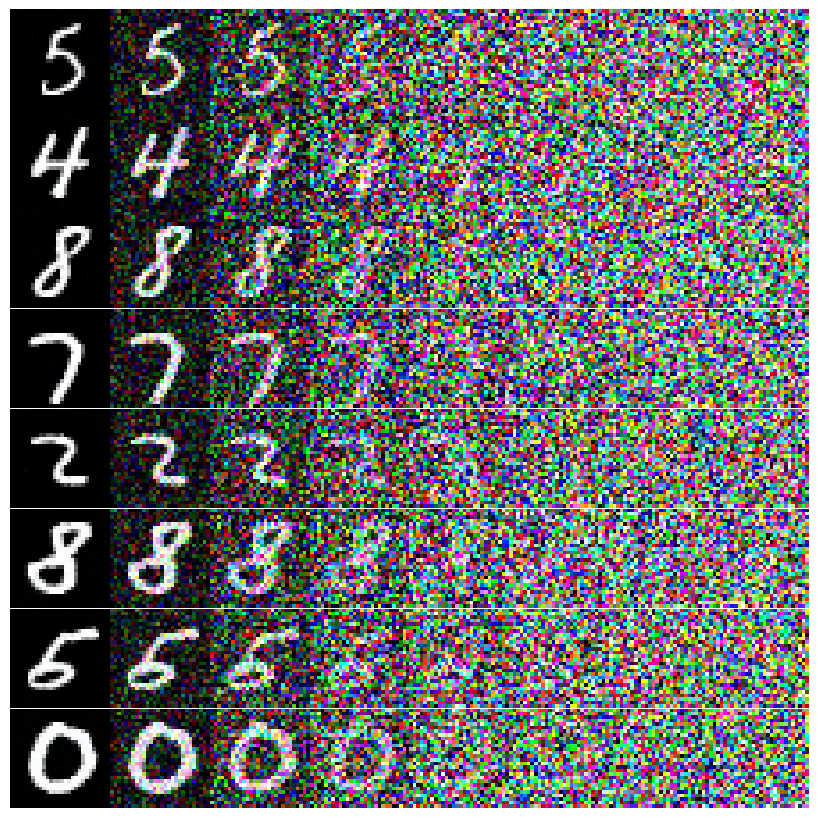

In [ ]:
# cell 12
#  扩散 8×8 可视化
viz(
     ckpt="/content/drive/MyDrive/Colab Notebooks/cv/hw3/output/ema_best.pt",
     out_png="/content/drive/MyDrive/Colab Notebooks/cv/hw3/runs/ddpm_mnist/diffusion_grid.png",
     timesteps=850,
     base=64
  )

In [ ]:
#cell 13
!git clone https://github.com/mseitzer/pytorch-fid.git
!pip install pytorch-fid

Cloning into 'pytorch-fid'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 298 (delta 70), reused 51 (delta 51), pack-reused 201 (from 3)
Receiving objects: 100% (298/298), 112.11 KiB | 14.01 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [ ]:
#cell 14
import pytorch_fid

!python -m pytorch_fid /content/drive/MyDrive/Colab Notebooks/cv/hw3/mnist

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py", line 313, in main
    fid_value = calculate_fid_given_paths(args.path,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py", line 253, in calculate_fid_given_paths
    raise RuntimeError('Invalid path: %s' % p)
RuntimeError: Invalid path: /content/drive/MyDrive/Colab


In [ ]:
#cell 15
# 计算 FID
# compute_fid("/content/drive/MyDrive/Colab Notebooks/cv/hw3/generate", "/path/to/mnist_rgb_train")
# compute_fid("/content/drive/MyDrive/Colab Notebooks/cv/hw3/generate", "/content/drive/MyDrive/Colab Notebooks/cv/hw3/mnist.npz")

# Trying to run pytorch_fid directly with user-provided command format
!python -m pytorch_fid "/content/drive/MyDrive/Colab Notebooks/cv/hw3/generate" "/content/drive/MyDrive/Colab Notebooks/cv/hw3/mnist.npz" --device cuda:0 --batch-size 16

100% 1/1 [00:00<00:00,  1.50it/s]
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py", line 313, in main
    fid_value = calculate_fid_given_paths(args.path,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py", line 263, in calculate_fid_given_paths
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_fid/fid_score.py", line 182, in calculate_frechet_distance
    assert sigma1.shape == sigma2.shape, \
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Training and test covariances have different dimension